In [1]:
import os
import numpy as np
import nibabel as nib
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import helper_functions.visualizations as vis
import importlib
import helper_functions.reshape_data as rd
import helper_functions.filter_CT as fct
import cv2
import time
from scipy.io import loadmat
from scipy.ndimage import affine_transform

In [2]:
root_data_dir = '/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/data' # Change for different systems
subject = 'subject_1'

# 'b' images seem to have fewer things around them, no pins in either
fluoro_jpeg_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'fluoro_' + subject + '.jpg'
    )
)
hull_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull_' + subject + '.nii'
    )
)

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'preopCT_' + subject + '.nii'
    )
)

hull_mat_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull.mat'
    )
)

In [3]:
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()
long_data = rd.voxels_to_4D(preop_CT_data)
preop_CT_data.shape


(256, 256, 176)

/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/CT_Segmentation/helper_functions/reshape_data.py:36: RuntimeWarning: Mean of empty slice
  projection = np.nanmean(ct_data, axis=axis)


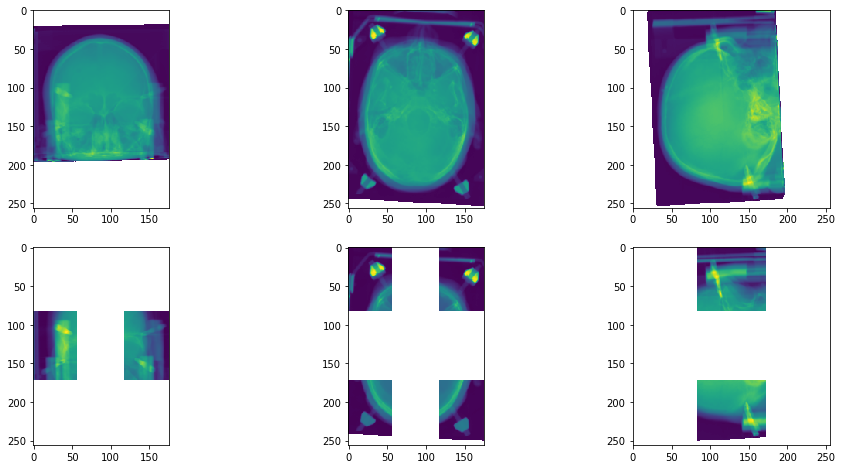

In [4]:
# Remove middle sections and edges to clean image
importlib.reload(fct)
filtered = fct.remove_ct_blocks(preop_CT_data, 35, 35, 35)
axes = vis.compare_filtered_original(preop_CT_data, filtered)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1331cf5f8>,
      dtype=object)

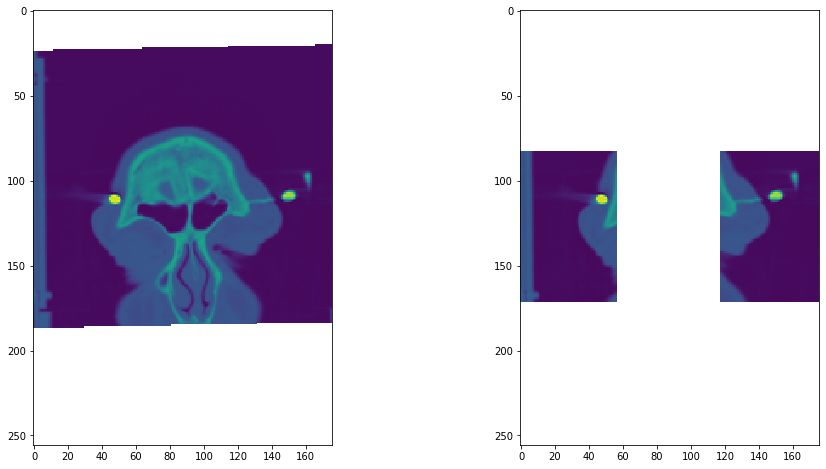

In [5]:
importlib.reload(vis)
vis.compare_slices([preop_CT_data, filtered], ['i'] * 2, [50] * 2)

# Using Scikit-image to find circles for the pin tips in 2D
- Goes through coronal plane slices to isolate circles

In [6]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.filters.rank import maximum
from skimage.draw import circle_perimeter


Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


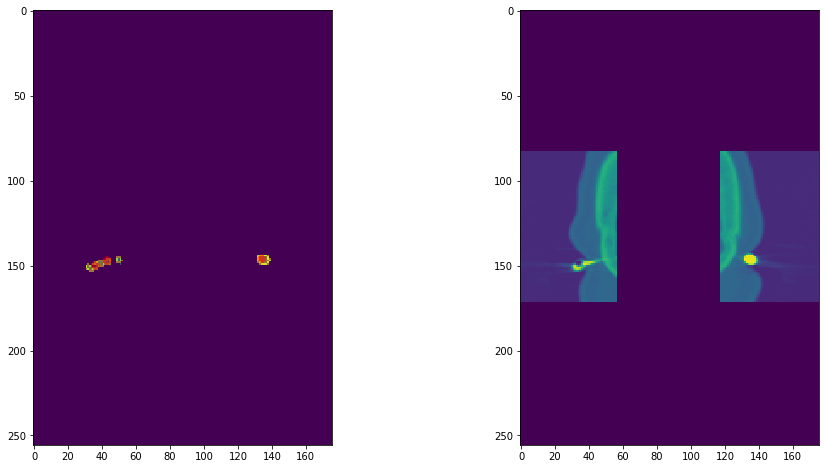

In [18]:
importlib.reload(fct)
min_max_filt = fct.min_max_normalize(filtered)
image_raw = np.nan_to_num(rd.get_slice(min_max_filt, 'i', 210))
max_filt_img = image_raw.copy()
max_filt_img[max_filt_img < .6] = 0

canny_filt = canny(max_filt_img, sigma=1)
# Detect two radii
hough_radii = np.arange(2, 10, 10)
hough_res = hough_circle(canny_filt, hough_radii)
# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image_raw.shape)
    axes[0].plot(circx, circy, '-r', alpha=0.5)
axes[0].imshow(max_filt_img)
axes[0].imshow(canny_filt, alpha=.5)
axes[1].imshow(image_raw);

In [12]:
importlib.reload(fct)
pin_tip_ct = fct.isolate_pin_tips(
    filtered,
    threshold=0.6,
    hough_radii=np.arange(2, 10, 10)
)
pin_tip_ct.shape

Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


(256, 256, 176)

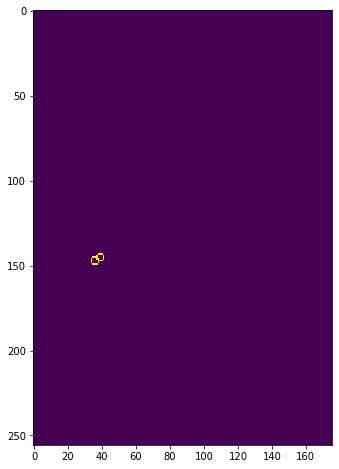

In [10]:
vis.plot_slice(pin_tip_ct, 'i', 200)

Plotting CT
Normalizing from: -1157.490478515625 3355.3486328125
To range: 0.0 1.0
Plotting features
Rendering


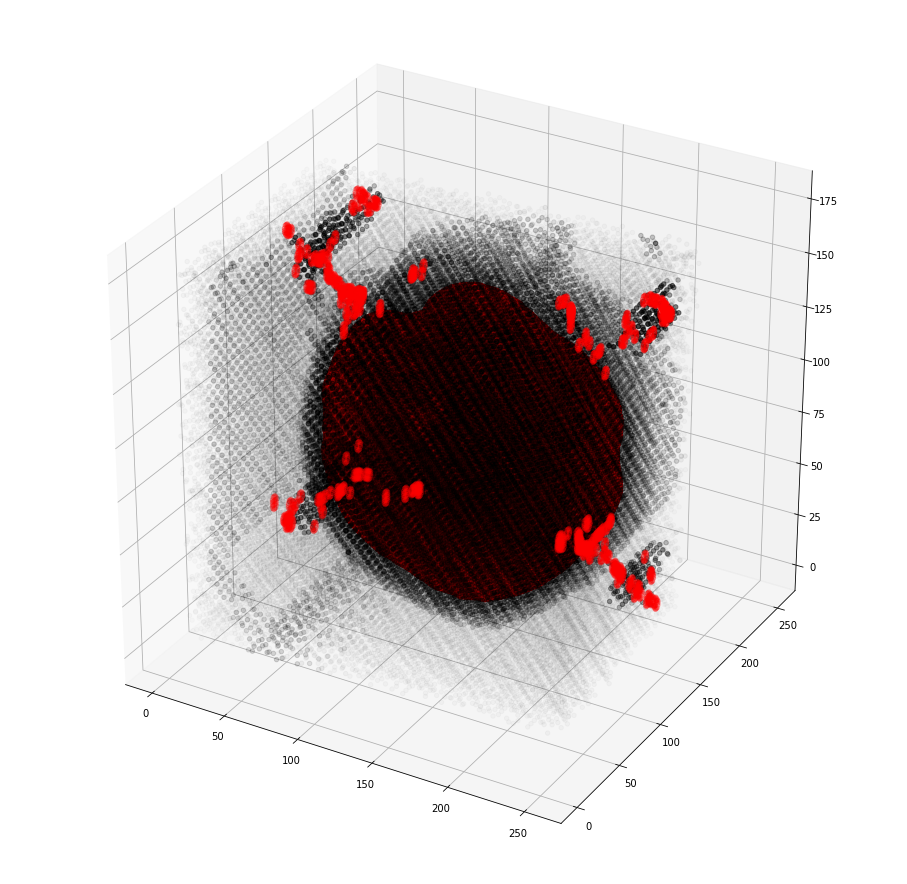

In [32]:
importlib.reload(vis)
print('Plotting CT')
ax = vis.quick_plot_3D(
    long_data,
    step_size=100,
    is_long=True
)
print('Plotting features')

vis.quick_plot_3D(
    pin_tip_ct/2,
    step_size=1,
    base_color=(1,0,0),
    is_norm=True,
    ax=ax
);

print('Plotting Hull')
vis.quick_plot_3D(
    hull_idx,
    step_size=1,
    base_color=(1,0,0),
    is_norm=True,
    is_long=True,
    ax=ax
);
print('Rendering')

## Saving feature space CT using affine and header from original
- TODO: check if the header correctly maps

In [13]:
feature_CT = nib.nifti2.Nifti2Image(pin_tip_ct, preop_CT.affine, header=preop_CT.header)

sizeof_hdr should be 540; set sizeof_hdr to 540


In [24]:
file_name = os.path.join(
    'output',
    subject + '_features.nii'
)
nib.nifti2.save(feature_CT, file_name)

# Loading hull and isolating skull

In [106]:
hull_idx = rwd.load_hull_from_mat(hull_mat_path, preop_CT)
print('Long form hull shape:', hull_idx.shape)

Long form hull shape: (53814, 4)


## Checking if cortical hull imports/looks correct on its own and with the CT

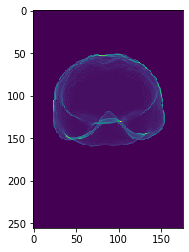

In [102]:
importlib.reload(rd)

hull_data = rwd.load_hull_voxel_matrix(hull_mat_path, preop_CT)
print('In voxels hull shape:')
plt.imshow(rd.project_ct_2D(hull_data, 0))

Normalizing from: -1601.8297119140625 3584.31884765625
To range: 0.0 1.0


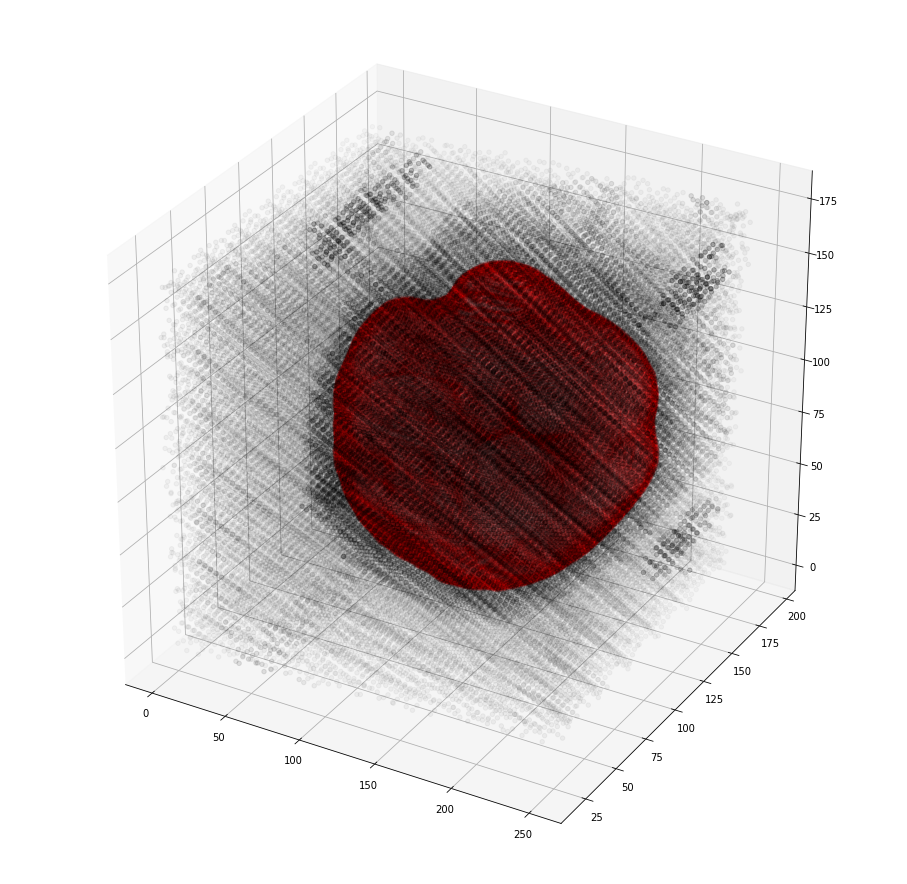

In [105]:
importlib.reload(vis)
ax = vis.quick_plot_3D(
    hull_idx,
    step_size=1,
    base_color=(1,0,0),
    is_norm=True,
    is_long=True,
    alpha_max=.1
)
vis.quick_plot_3D(
    fct.min_max_normalize(preop_CT_data),
    step_size=100,
    is_norm=True,
    is_long=False,
    ax=ax,
    alpha_max=0.5
)

In [34]:
hull_idx[0]

array([223., 131., 102.,   1.])

In [24]:
print(feature_CT.affine,'\n\n', feature_CT.get_sform())

[[ 0.00000000e+00  2.44321823e-02  9.99404013e-01 -9.05629578e+01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  1.08193840e+02]
 [ 0.00000000e+00 -9.99701500e-01  2.44249105e-02  1.15094421e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

 [[ 0.00000000e+00  2.44321823e-02  9.99404013e-01 -9.05629578e+01]
 [-1.00000000e+00  0.00000000e+00  0.00000000e+00  1.08193840e+02]
 [ 0.00000000e+00 -9.99701500e-01  2.44249105e-02  1.15094421e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [20]:
dir(feature_CT)

['ImageArrayProxy',
 'ImageSlicer',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_affine',
 '_affine2header',
 '_compressed_suffixes',
 '_data',
 '_data_cache',
 '_dataobj',
 '_fdata_cache',
 '_get_fileholders',
 '_header',
 '_meta_sniff_len',
 '_sniff_meta_for',
 'affine',
 'as_reoriented',
 'dataobj',
 'extra',
 'file_map',
 'files_types',
 'filespec_to_file_map',
 'filespec_to_files',
 'from_bytes',
 'from_file_map',
 'from_filename',
 'from_files',
 'from_image',
 'get_affine',
 'get_data',
 'get_data_dtype',
 'get_fdata',
 'get_filename',
 'get_header',
 'get_qform',
 'get_sform',
 'get_shape',
 'header',
 'header_class',
 'in_memory',
 'instan